__Étudiante__ : Madina TRAORÉ

#### Imports

In [1]:
import copy
import random
import numpy as np
from ipynb.fs.defs.toolbox import softmax
from ipynb.fs.defs.mdp import maze_mdp # Markov Decision Process # RETIRER LES OCCURENCES DE "%notebook" DE mdp.py
                                       # POUR QUE CET IMPORT PUISSE SE FAIRE
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

# N-step Q-learning

In this part, we implement the N-step variant of the Q-learning algorithm, using a replay buffer as we did for studying the off-policy property of Q-learning.

Using the N-Steps return accelerates the learning process by updating the Q values of $N-1$ states at a time, by recording together succesive states visited by the agent.

In this lab, we focus on updating the states visited by the agent when following its policy until he reached its current state.

### Create a class NStepSample

An N-step sample contains N samples, corresponding to N consecutive steps of an agent.

In the cell below, import the Sample class from the [on_off_policy.ipynb](on_off_policy.ipynb) notebook and create a class to store an N-step sample.

In [2]:
class Sample():

    def __init__(self, x, a, r, next_x):
        self.x = x
        self.a = a
        self.r = r
        self.next_x = next_x

In [3]:
class NStepSample():
    
    def __init__(self, N):
        self.N = N
        self.samples = []
    
    def add(self, sample):
        if len(self.samples) < self.N:
            self.samples.append(sample)
        else:
            self.samples = copy.deepcopy(self.samples)
            self.samples.pop(0)
            self.samples.append(sample)

If this is necessary, adapt your class ReplayBuffer so that it can contain N-step samples instead of simple samples. Maybe no adaptation is necessary if you make so that the class NStepSample inherits from Sample.

In [4]:
class NStep_ReplayBuffer():

    def __init__(self, size):
        self.NStep_samples = []
        self.size = size
    
    def add(self, NStep_sample):
        if len(self.NStep_samples) < self.size:
            self.NStep_samples.append(NStep_sample)
    
    def draw(self):
        return random.choice(self.NStep_samples)

Create the necessary code so that an agent running a specific policy can fill a replay buffer with the steps it is taking in the environment. After its N-1 first steps, each time the agent takes a step, it adds an N-step sample to the replay buffer. Thus the replay buffer contains samples about the same steps several times, but shifted.

![N-step-return|50x50](N-step-return.png)

Create a function which, given a policy, a replay buffer and a number of steps N (take for instance N = 5) runs a simulation of the agent in its environment.
    
After the agent's N-1 first steps, start saving, at each step, the N data (state + action + reward) gathered into the replay buffer. In order to do that, use the NStepSample objects.

In [5]:
def simulation(mdp, policy, replay_buffer, N):
    x = mdp.reset(uniform=True) 
    done = mdp.done()
    i = 1
    nstep_sample = NStepSample(N)
    while not done:
        [y,r,done,info] = mdp.step(int(policy[x]))
        if i < N:
            nstep_sample.add(Sample(x,int(policy[x]),r,y))
        else:
            replay_buffer.add(nstep_sample)
            n_step_sample = copy.deepcopy(nstep_sample)
            n_step_sample.add(Sample(x,int(policy[x]),r,y))
        i+=1
        
        # Update the agent's position
        x = y
        
    replay_buffer.add(nstep_sample)

Copy-paste your modified Q-learning code from the [on_off_policy.ipynb](on_off_policy.ipynb) notebook.
Modify it again so that it takes N-step samples as input rather than single samples.

Hint : You can generate two Q-tables in your Q-Learning algorithm, one that performs the nsteps update and one that doesn't, this will help you analyze your results.

In [6]:
def QLearning_with_replay_buffer_nstep(mdp,tau,replay_buffer,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
        
    for i in range(nEpisodes) :
        done = False
        
        # Draw a sample from the replay buffer
        nstep_sample = replay_buffer.draw()
        
        for sample in nstep_sample.samples:
            x = sample.x
            mdp.current_state = x
            
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
                    
            u = sample.a
            y = sample.next_x
            r = sample.r
            done = mdp.done()

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                Qmax = Q.max(axis=1)
                delta = r + mdp.gamma*Qmax[y] - Q[x,u]
                Q[x,u] += alpha*delta
            
            done = mdp.done()
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

Finally, write a code that:

* creates a replay buffer with a size of 10.000 samples, fills it with N-step samples coming from an agent running one or several different policies,
* makes Q-learning learn from samples drawn uniformly from this replay buffer, until a fixed number of episodes ,
* visualizes the results.

 
Hint : you can play with your algorithm, using different policies when generating your samples, updating your ReplayBuffer in the Q-Learning algorithm above with newly generated samples from your policy and increasing either the size of the buffer or the number of episodes. You can then compare the effectiveness of the different variations of your algorithm.

In [7]:
########################### Policy Iteration ###########################
# Given a MDP, this algorithm computes the optimal state value function V
# It then derives the optimal policy based on this function

def PI_V(mdp, render=True): #Value Iteration using the state value V
     
    V = np.zeros((mdp.observation_space.size)) #initial state values are set to 0
    pol = np.zeros((mdp.observation_space.size)) #initial policy set to always go north
    quitt = False
    
    V_list = [V.copy()] #list of the state values computed over time (used to generate an animation)
    policy_list = [pol.copy()] #list of the policies computed over time (used to generate an animation)
    
    if render:
        mdp.new_render()
    
    i = 0
    while quitt==False:
        i += 1
        Vold = V.copy()
        if render:
            mdp.render(V, pol)
        
        # Step 1 : Policy Evaluation
        for x in mdp.observation_space.states: #for each state x
            # Compute the value of the state x 
            
            if not x in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                v = 0
                for y in mdp.observation_space.states:
                    v += mdp.r[x,int(pol[x])] + mdp.gamma*mdp.P[x,int(pol[x]),y]*Vold[y]
                V[x] = v
            else : # if it is a final state, then we only take the reward into account
                v = mdp.r[x,int(pol[x])]
                V[x] = v

        # Step 2 : Policy Improvement
        
        for x in mdp.observation_space.states:
            V_temp = []
            for u in mdp.action_space.actions:
                v = 0
                for y in mdp.observation_space.states:
                    v += mdp.r[x,u] + mdp.gamma*mdp.P[x,u,y]*V[y]
                V_temp.append(v)
            # Set the policy for this state as the action u that maximizes the state value of x
            pol[x] = np.argmax(V_temp)
        
        V_list.append(V.copy())
        policy_list.append(pol.copy())
    
        # Test if convergence has been reached
        if i > 10 and (np.linalg.norm(V-Vold)) < 0.01 :
            quitt = True
    
    if render:
        mdp.render(V, pol)
    
    return [V_list, policy_list]

<IPython.core.display.Javascript object>


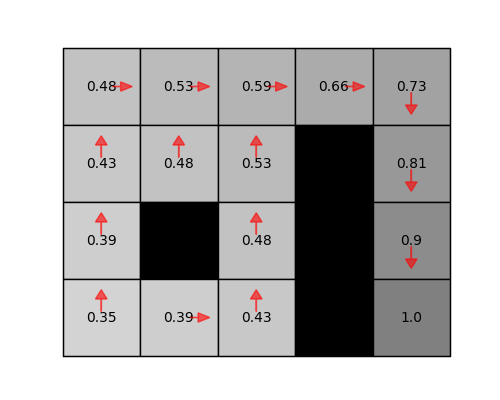

In [8]:
%matplotlib notebook

walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

[V_list, policy_list] = PI_V(m,render=True)

<IPython.core.display.Javascript object>


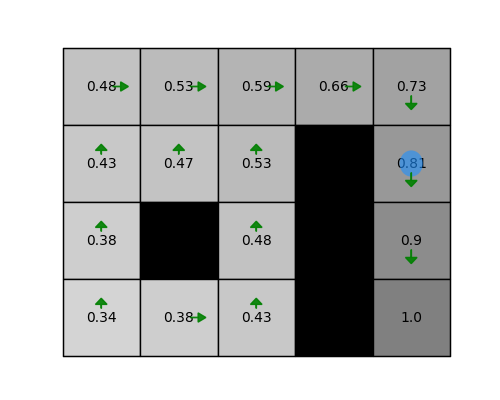

In [9]:
%matplotlib notebook

size = 10000
policy = policy_list[-1]
N = 5
replay_buffer = NStep_ReplayBuffer(size)
while len(replay_buffer.NStep_samples) < size:
    simulation(m, policy, replay_buffer, N)
    
[Q_list, policy_list] = QLearning_with_replay_buffer_nstep(m,0.1,replay_buffer,nEpisodes=1000,nTimesteps=50,alpha=0.1,render=True)